In [4]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import itertools
#from bs4 import BeautifulSoup
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
#import sklearn.cross_validation as cv
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [5]:
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod', autocommit=True)

In [994]:
train = """
select basic.player_id,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
      -- box_view.home_away,
       basic.pts,
       basic.minutes_played,
       basic.fga,
       basic.3pa,
       basic.orb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       a_stats.pie,
       adv.offensive_rating,
       reg_avg.fg_a as tot_fg_a,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to,
       opp_team_pts.opp_pts,
       opp_team_pts.diff,
       misc.FBPS,
       misc.second_chance_pts

from (

     select b.game_hash,
            b.home_team as team,
            b.game_date,
            team.team_id as away_id,
            lu.season
     from box_score_map as b
     inner join game_date_lookup as lu on b.game_date = lu.day
     inner join team_info as team on b.away_team = team.team
     where b.game_date < current_date and
           lu.season > 2005 

     ) as box_view

inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
play_m.player_id = adv.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (box_view.season -1 = reg_avg.season) )
inner join points as opp_team_pts on box_view.away_id = opp_team_pts.team_id and box_view.season -1 = opp_team_pts.season
inner join team_misc_boxscore_stats as misc on ( (box_view.game_hash = misc.game_hash) and (box_view.team = misc.team) )
order by box_view.game_date desc;

"""

In [995]:
df = pd.read_sql(sql=train, con=conn, index_col=None)

In [996]:
def time_convert(minutes_played):
    time_list = minutes_played.split(':')
    try:
        return ((int(time_list[0]) * 60) + int(time_list[1]))
    except ValueError:
        return 0

In [997]:
def concat_drop(df, dummy_var_col, drop_list):
    for field in dummy_var_col:
        df = pd.concat([df, gen_dummby_var(df, field)], axis=1)
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [998]:
def gen_dummby_var(df, column):
    return pd.get_dummies(df[column], drop_first=True)

In [999]:
df.loc[:, 'minutes_played'] = df.loc[:, 'minutes_played'].apply(time_convert)

In [1000]:
df.drop([ 'player_id', 'team', 'game_hash', 'game_date'], axis=1, inplace=True)
clean_df = df[df['minutes_played'] >= 420]
#clean_df = concat_drop(df[df['minutes_played'] >= 900], ['home_away'], [ 'player_id', 'team', 'game_hash', 'game_date'])

In [1001]:
#clean_df.drop('Home', inplace=True, axis=1)
clean_df.head()
#group_df = clean_df.groupby(['game_date','team'])
#group_df.head()

,pts,minutes_played,fga,3pa,orb,trb,ast,stl,blk,tov,...,tot_reb,tot_ast,tot_blk,tot_stl,tot_pf,tot_to,opp_pts,diff,FBPS,second_chance_pts
0,32,2204,21,6,2,5,4,1,0,2,...,3.9,2.7,0.2,1.1,2.2,1.6,103.0,2.6,5,14
1,19,1544,15,5,1,3,3,0,0,2,...,2.0,4.7,0.1,0.7,1.2,1.2,103.0,2.6,5,14
2,2,1026,5,0,1,3,1,1,0,1,...,3.7,1.4,0.4,1.1,1.8,1.1,103.0,2.6,5,14
3,14,2205,8,5,2,14,2,3,1,0,...,6.9,1.0,0.3,0.6,1.2,0.8,103.0,2.6,5,14
4,14,2205,8,5,2,14,2,3,1,0,...,5.1,0.4,0.3,0.2,1.3,0.5,103.0,2.6,5,14


In [1002]:
#for group in group_df.groups:
 #   print(group)

In [1003]:
clean_df = clean_df.fillna(0)

In [1004]:
x = clean_df.loc[:, 'minutes_played':]
y = clean_df.loc[:, 'pts']

In [1005]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.loc[:, 'minutes_played':], clean_df.loc[:, 'pts'], test_size=.33)

In [1006]:
lm = LinearRegression()

In [1007]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1008]:
predictions = lm.predict(X_test)

Text(0,0.5,'Predicted Y')

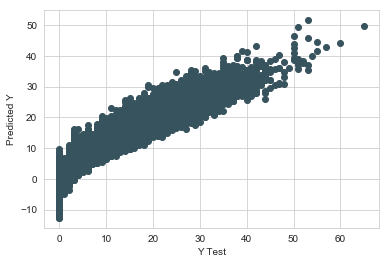

In [1009]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

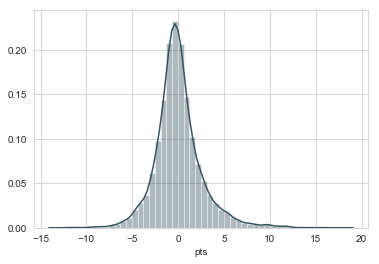

In [1010]:
sns.distplot((y_test-predictions),bins=50);

In [1011]:
coeffecients = pd.DataFrame(lm.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.002477
fga,0.849390
3pa,0.050857
orb,-0.372406
trb,0.034605
ast,-0.283865
stl,0.025532
blk,0.033696
tov,0.114216
pf,-0.003719


In [1012]:
lm.score(X_test, y_test)

0.89172404116636406

In [909]:
### Experimenting with Lasso regression

In [910]:
lasso = Lasso(alpha=0.0023101297000831605)  #Home: 0.00174333 - 0.00221222

In [911]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.0023101297000831605, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [912]:
predictions = lasso.predict(X_test)

Text(0,0.5,'Predicted Y')

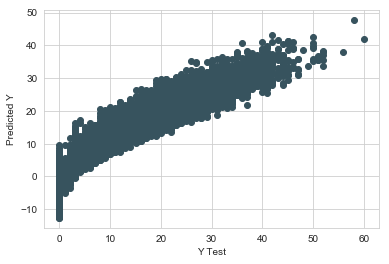

In [913]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

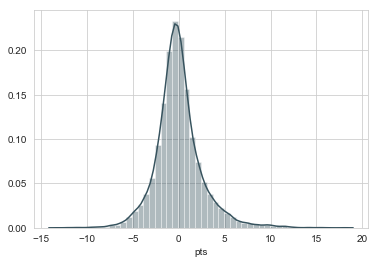

In [914]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.distplot(y_test-predictions, bins=50)

In [915]:
lasso.score(X_test, y_test)

0.89379683930393405

In [916]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.002463
fga,0.845509
3pa,0.057772
orb,-0.379354
trb,0.032231
ast,-0.281271
stl,0.028555
blk,0.037253
tov,0.131468
pf,-0.005475


In [917]:
#### Using Lasso cross-validation model

In [918]:
lasso_cv = LassoCV()

In [919]:
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [920]:
predictions_cv = lasso_cv.predict(X_test)

Text(0,0.5,'Predicted Y')

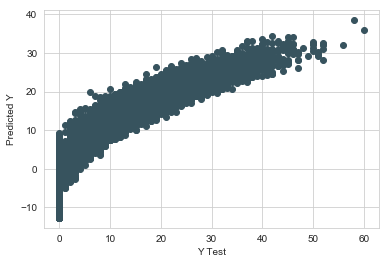

In [921]:
plt.scatter(y_test,predictions_cv)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

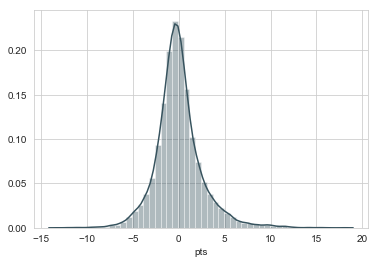

In [922]:
sns.distplot(y_test-predictions, bins=50)

In [923]:
lasso_cv.score(X_test, y_test)

0.85434119571395317

In [924]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.002463
fga,0.845509
3pa,0.057772
orb,-0.379354
trb,0.032231
ast,-0.281271
stl,0.028555
blk,0.037253
tov,0.131468
pf,-0.005475


In [925]:
### optimizing alpha value in Lasso regression

In [926]:
alphas = np.logspace(-4, -1, 50)
#alphas = np.linspace(.001, .999, 100) #0.00464159
#alphas

In [927]:
scores = np.empty_like(alphas)

In [928]:
for i, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)

In [929]:
lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(x, y)
cv_score = lasso_cv.score(x, y)
cv_alpha = lasso_cv.alpha_
cv_alpha, cv_score, lasso_cv.coef_, lasso_cv.intercept_

(0.0068664884500429981,
 0.892795207910966,
 array([  2.50674973e-03,   8.43684095e-01,   5.25346856e-02,
         -3.69366390e-01,   3.10654596e-02,  -2.79343563e-01,
          2.10975454e-02,   3.48809954e-02,   1.02531659e-01,
         -0.00000000e+00,   6.36313200e-02,   1.95163555e-01,
          5.24511068e-02,   1.37659048e-02,   8.05048980e-02,
         -9.10309671e-02,  -1.39514102e-02,   5.43401696e-01,
          3.28396389e-02,  -7.86414846e-04,   2.08727451e-02,
         -2.24571066e-02,  -1.02727933e-01,   0.00000000e+00,
         -1.62270179e-03,  -2.37908138e-03,   3.58905638e-03,
         -2.05471932e-02]),
 -18.411323828575121)

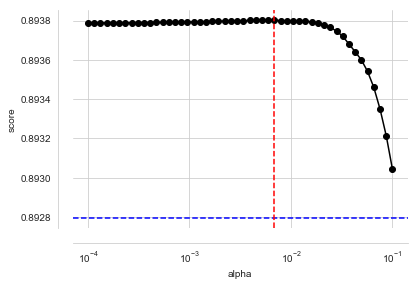

In [930]:
plt.plot(alphas, scores, '-ko')
plt.axhline(cv_score, color='b',ls='--')
plt.axvline(cv_alpha, color='r', ls='--')
plt.xlabel('alpha')
plt.ylabel('score')
plt.xscale('log')
sns.despine(offset=15)

In [931]:
predictions = lasso_cv.predict(X_test)

In [932]:
lasso_cv.score(x, y)

0.892795207910966

In [933]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.80854002584
MSE: 6.56456685191
RMSE: 2.56214106792


In [934]:
np.amax(scores)

0.89380169493231743

In [935]:
np.take(alphas, np.argmax(scores))

0.0059636233165946424

Text(0,0.5,'predictions')

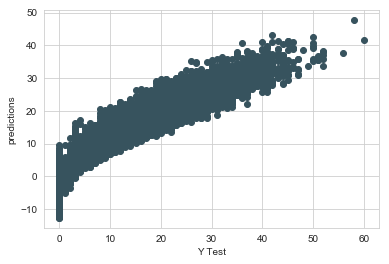

In [936]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('predictions')